# Requirements
- python 3.6.8 (3.5 should suffice)
- pip dependancies:
    - numpy
    - scipy
    - pandas
    - matplotlib
    - sklearn
    - keras
    - tensorflow

# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

from scipy.stats import yulesimon

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
RANDOM_STATE = 17
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=RANDOM_STATE)


# Generate data

In [2]:
def generate_data(num_alphas, samples_per_alpha, rvs_size, min_alpha=2.01, max_alpha=3.00, random_state=0):
    '''
    params:
        num_alphas: number of alphas generated between (min_alpha) and (max_alpha) inclusive
        samples_per_alpha: number of samples (rows) for each alpha 
        rvs_size: number of RV samples (columns) per row
    '''

    # fix loc at zero
    loc = 0

    X = np.empty((num_alphas * samples_per_alpha, 1 + rvs_size), float)

    row = 0
    for alpha in np.linspace(min_alpha, max_alpha, num=num_alphas):
        
        #lilo
        # alpha = round(alpha, 2)
        
        # generate samples (rows) for current alpha
        for i in range(samples_per_alpha):
            X[row, 0] = alpha
            X[row, 1:] = yulesimon.rvs(alpha, loc=loc, size=rvs_size, random_state=random_state)
            row += 1

    #lilo
    # suffle rows
    # np.random.shuffle(X)

    # separate X from y
    y = X[:, 0]
    X = X[:, 1:].astype(int)

    # create a histogram (H) from (X) rows
    nbins = np.max(X)
    H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

    # log scale (H) rows
    logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)
    return logH, y

# Create Model

In [3]:
def create_model(n_features, 
                 layers, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    
    # ============
    # input-layer
    # ============
    model.add(Dense(units=layers[0]
                      , input_dim=n_features
                      , kernel_initializer=init
                      , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                      , activity_regularizer=l2(a_reg_lr) if a_reg else None
                      , use_bias= (not batch_normalization)
                    ))
    
    
    if batch_normalization:
        model.add(BatchNormalization())
    
    model.add(Activation(activation))

    if dropout > 0:
        model.add(Dropout(dropout))

    # ==============
    # hidden-layers
    # ==============
    for units in layers[1:]:
        model.add(Dense(units=units
                        , kernel_initializer=init
                        , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                        , activity_regularizer=l2(a_reg_lr) if a_reg else None
                        , use_bias= (not batch_normalization)
                        ))

    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation(activation))
    
    if dropout > 0:
        model.add(Dropout(dropout))

    # =============
    # output-layer
    # =============
    model.add(Dense(units=1
                    , kernel_initializer=init
                    , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                    , activity_regularizer=l2(a_reg_lr) if a_reg else None
                    , use_bias= (not batch_normalization)
                    ))
    
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation('linear'))
    
    # if dropout > 0:
    #     model.add(Dropout(dropout))

    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

    return model

# Training

In [4]:
def train(X_train, y_train, X_val, y_val, layers=[256, 256], batch_size=32):
    model = create_model(X_train.shape[1], 
                         layers=layers, 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=True, 
                         dropout=0.0, 
                         optimizer=Adam(lr=1e-2), 
                         #optimizer=SGD(lr=1e-3, momentum=0.9, decay=0.01), 
                         k_reg=True, 
                         k_reg_lr=1e-5, 
                         a_reg=True, 
                         a_reg_lr=1e-5)
    
    # early-stopping
    es_patience = 50
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=0)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/yulesimon_{}'.format(date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=3000, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        callbacks=[es, reduce_lr, cp], 
                        verbose=0)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    model = keras.models.load_model(model_path)
    return model, history.history

In [5]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.figure(figsize=(2,2))
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

# Trials

In [6]:
def trial(num_alphas, samples_per_alpha, rvs_size, layers=[256, 256], batch_size=32):
    sqrt_mse, model, history = _trial(num_alphas, samples_per_alpha, rvs_size)
    return sqrt_mse

def _trial(num_alphas, samples_per_alpha, rvs_size, layers=[256, 256], batch_size=32):
    print('working... started at: {}'.format(datetime.now().strftime('%H:%M:%S')), end='\t')
    start = time.time()
    
    X, y = generate_data(num_alphas=num_alphas, samples_per_alpha=samples_per_alpha, rvs_size=rvs_size, random_state=RANDOM_STATE)

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # split train/val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

    # training
    model, history = train(X_train, y_train, X_val, y_val, layers)

    # predict
    y_pred = model.predict(X_test).flatten()

    # evaluate
    squared_error = np.square(y_test - y_pred)
    mse = (squared_error).mean(axis=0)

    end = time.time()
    print('took: {:.2f} sec'.format(end-start))

    return np.sqrt(mse), model, history

## Baseline

working... started at: 16:50:22took: 72.63 sec
sqrt(mse) = 0.0064877092581074845


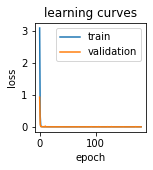

In [7]:
sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=100, rvs_size=1000, layers=[256,256], batch_size=32) # 0.0064877092581074845
#sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=100, rvs_size=1000, layers=[32,32], batch_size=32)  # 0.0057517
print('sqrt(mse) = {}'.format(sqrt_mse))
plot_learning_curves(h)

## Lower samples_per_alpha

working... started at: 16:51:35took: 20.10 sec
sqrt(mse) = 0.007714012850908444


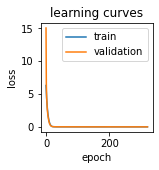

In [8]:
sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=10, rvs_size=1000, layers=[256,256], batch_size=32)   # 0.007714012850908444
print('sqrt(mse) = {}'.format(sqrt_mse))
plot_learning_curves(h)

## Chaning num_alphas

working... started at: 16:51:55took: 61.50 sec
sqrt(mse) =  0.006939887527228205


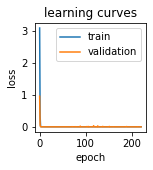

In [9]:
sqrt_mse, m, h = _trial(num_alphas=1000, samples_per_alpha=10, rvs_size=1000, layers=[32,32], batch_size=32)    # 0.006939887527228205
print('sqrt(mse) = ', sqrt_mse)
plot_learning_curves(h)

## Lower rvs_size (1000->100)

working... started at: 16:52:57took: 66.07 sec
sqrt(mse) =  0.02103048777773732


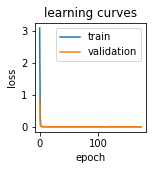

In [10]:
sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=100, rvs_size=100, layers=[256,256], batch_size=32)
print('sqrt(mse) = ', sqrt_mse)
plot_learning_curves(h)

## Lower rvs_size (100->10)

working... started at: 16:54:03took: 37.02 sec
sqrt(mse) =  0.12124246365592901


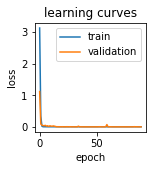

In [11]:
sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=100, rvs_size=10, layers=[256,256], batch_size=32)
print('sqrt(mse) = ', sqrt_mse)
plot_learning_curves(h)

## Lower samples_per_alpha (100->10)

working... started at: 16:54:40took: 20.31 sec
sqrt(mse) =  0.007714012850908444


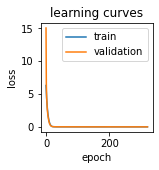

In [12]:
sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=10, rvs_size=1000, layers=[256,256], batch_size=32)
print('sqrt(mse) = ', sqrt_mse)
plot_learning_curves(h)

## Raise samples_per_alpha (100->1000)

In [14]:
if False:
    # sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=1000, rvs_size=1000, layers=[32,32], batch_size=32) # 0.008573854791379563
    sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=1000, rvs_size=1000, layers=[256,256], batch_size=32) #0.012766941637065174
    print('sqrt(mse) = ', sqrt_mse)
    plot_learning_curves(h)

## Larger dataset (100,1000 rows / 1000 columns)

working... started at: 17:42:44took: 474.96 sec
sqrt(mse) = 0.008573854791379563


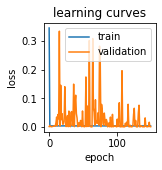

In [17]:
if False:
    sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=1000, rvs_size=1000, layers=[32,32], batch_size=32)  # 0.008573854791379563
    print('sqrt(mse) = {}'.format(sqrt_mse))
    plot_learning_curves(h)

In [ ]:
sqrt_mse, m, h = _trial(num_alphas=100, samples_per_alpha=1000, rvs_size=10000, layers=[32,32], batch_size=32)  # 
print('sqrt(mse) = {}'.format(sqrt_mse))
plot_learning_curves(h)